Initialize Spark Session and Load Data:

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TwitterSentimentAnalysis") \
    .config("spark.master", "local[*]") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()


24/05/20 09:12:07 WARN Utils: Your hostname, muhammad-VM resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/05/20 09:12:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/20 09:12:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load the CSV file from HDFS
df = spark.read.csv("hdfs://localhost:9000/data/projecttweets/ProjectTweets.csv", header=True, inferSchema=True)

# Show the schema and the first few rows
df.printSchema()
df.show(20)


root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthami

Basic Data Exploration:

In [3]:
# Assign meaningful column names
columns = ["id", "tweet_id", "date", "query", "user", "text"]
for old_name, new_name in zip(df.columns, columns):
    df = df.withColumnRenamed(old_name, new_name)

# Show the renamed columns to ensure they are correct
df.printSchema()
df.show(5)

root
 |-- id: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+---+----------+--------------------+--------+-------------+--------------------+
| id|  tweet_id|                date|   query|         user|                text|
+---+----------+--------------------+--------+-------------+--------------------+
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+---+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



In [4]:
from pyspark.sql.functions import col, count, when

# Check for null values in the DataFrame after renaming columns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+--------+----+-----+----+----+
| id|tweet_id|date|query|user|text|
+---+--------+----+-----+----+----+
|  0|       0|   0|    0|   0|   0|
+---+--------+----+-----+----+----+



In [5]:
# Drop rows with null values in critical columns
df_cleaned = df.dropna(subset=['tweet_id', 'user', 'text'])

# Remove duplicate rows
df_cleaned = df_cleaned.dropDuplicates()

# Show the schema and the first few rows of the cleaned DataFrame
df_cleaned.printSchema()
df_cleaned.show(5)

# Check again for null values in the cleaned DataFrame
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

# Validate data types
df_cleaned.printSchema()

# Cast columns to correct data types if necessary
df_cleaned = df_cleaned.withColumn("id", df_cleaned["id"].cast("integer")) \
                       .withColumn("tweet_id", df_cleaned["tweet_id"].cast("long")) \
                       .withColumn("date", df_cleaned["date"].cast("string")) \
                       .withColumn("query", df_cleaned["query"].cast("string")) \
                       .withColumn("user", df_cleaned["user"].cast("string")) \
                       .withColumn("text", df_cleaned["text"].cast("string"))

# Show the schema and the first few rows after data type correction
df_cleaned.printSchema()
df_cleaned.show(5)


root
 |-- id: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



+------+----------+--------------------+--------+---------------+--------------------+
|    id|  tweet_id|                date|   query|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
| 80097|1752157726|Sat May 09 21:11:...|NO_QUERY|     crisssycat|          i want ...|
|271505|1990029536|Mon Jun 01 03:38:...|NO_QUERY|       Jana1503|  David must be h...|
|475465|2177612419|Mon Jun 15 06:24:...|NO_QUERY|LuckyTheMeerkat|  I wanted to sle...|
|130856|1835395104|Mon May 18 05:53:...|NO_QUERY|    mstellacrap| ..sniffles... si...|
|258386|1985179547|Sun May 31 16:35:...|NO_QUERY|         Mush3l| 2nd item did not...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



+---+--------+----+-----+----+----+
| id|tweet_id|date|query|user|text|
+---+--------+----+-----+----+----+
|  0|       0|   0|    0|   0|   0|
+---+--------+----+-----+----+----+

root
 |-- id: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



+------+----------+--------------------+--------+---------------+--------------------+
|    id|  tweet_id|                date|   query|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
| 80097|1752157726|Sat May 09 21:11:...|NO_QUERY|     crisssycat|          i want ...|
|271505|1990029536|Mon Jun 01 03:38:...|NO_QUERY|       Jana1503|  David must be h...|
|475465|2177612419|Mon Jun 15 06:24:...|NO_QUERY|LuckyTheMeerkat|  I wanted to sle...|
|130856|1835395104|Mon May 18 05:53:...|NO_QUERY|    mstellacrap| ..sniffles... si...|
|258386|1985179547|Sun May 31 16:35:...|NO_QUERY|         Mush3l| 2nd item did not...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



Sentiment Analysis

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from textblob import TextBlob


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Define a function to compute sentiment polarity using TextBlob
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

# Register the function as a UDF
sentiment_udf = udf(get_sentiment, DoubleType())

# Apply the UDF to the 'text' column to compute sentiment
df_with_sentiment = df_cleaned.withColumn("sentiment", sentiment_udf(col("text")))

# Show the first few rows with the new sentiment column
df_with_sentiment.show(5)

# Group by sentiment and count occurrences
sentiment_counts = df_with_sentiment.groupBy("sentiment").count()

# Show the results
sentiment_counts.show()

# Group by user and calculate average sentiment
user_sentiment = df_with_sentiment.groupBy("user").avg("sentiment").withColumnRenamed("avg(sentiment)", "avg_sentiment")

# Show the top 5 users with the highest average sentiment
user_sentiment.orderBy("avg_sentiment", ascending=False).show(5)




/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+------+----------+--------------------+--------+---------------+--------------------+--------------------+
|    id|  tweet_id|                date|   query|           user|                text|           sentiment|
+------+----------+--------------------+--------+---------------+--------------------+--------------------+
| 80097|1752157726|Sat May 09 21:11:...|NO_QUERY|     crisssycat|          i want ...|                 0.0|
|271505|1990029536|Mon Jun 01 03:38:...|NO_QUERY|       Jana1503|  David must be h...|                 0.0|
|475465|2177612419|Mon Jun 15 06:24:...|NO_QUERY|LuckyTheMeerkat|  I wanted to sle...| 0.24375000000000002|
|130856|1835395104|Mon May 18 05:53:...|NO_QUERY|    mstellacrap| ..sniffles... si...|0.004166666666666689|
|258386|1985179547|Sun May 31 16:35:...|NO_QUERY|         Mush3l| 2nd item did not...|                 0.0|
+------+----------+--------------------+--------+---------------+--------------------+--------------------+
only showing top 5 rows



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+-----+
|           sentiment|count|
+--------------------+-----+
| 0.45499999999999996|  296|
|-0.21749999999999997|    4|
| -0.4277777777777777|   57|
|  0.1452020202020202|    5|
| 0.39333333333333337|   12|
|0.012121212121212116|   35|
|0.002083333333333312|    2|
|  0.3621794871794872|    1|
|  0.1766666666666667|    4|
|0.009999999999999986|   13|
| -0.4603174603174603|    4|
|-0.33888888888888896|    4|
|-0.01481481481481...|    2|
| 0.12727272727272726|   23|
| -0.1685185185185185|   15|
|-0.09035714285714284|    1|
| 0.06857142857142855|    1|
|-0.02291666666666...|    3|
|-0.08611111111111108|    1|
| 0.11688311688311688|    5|
+--------------------+-----+
only showing top 20 rows



+-------------+-------------+
|         user|avg_sentiment|
+-------------+-------------+
|    lorinelly|          1.0|
|      tournxg|          1.0|
|morgrochele21|          1.0|
| itskaseyface|          1.0|
|   Shamiamwow|          1.0|
+-------------+-------------+
only showing top 5 rows



In [8]:
from pymongo import MongoClient
import pandas as pd

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["twitter_sentiment"]
collection = db["tweets"]

# Assuming df_with_sentiment is your cleaned and processed DataFrame with sentiment scores
# Sample DataFrame for demonstration
data = {
    "id": [1, 2, 3],
    "tweet_id": [123456, 789012, 345678],
    "date": ["2024-05-01", "2024-05-02", "2024-05-03"],
    "query": ["query1", "query2", "query3"],
    "user": ["user1", "user2", "user3"],
    "text": ["This is a tweet", "Another tweet", "Yet another tweet"],
    "sentiment": [0.1, 0.5, -0.2]
}

# Convert the dictionary to a Pandas DataFrame
df_with_sentiment = pd.DataFrame(data)

# Convert the Spark DataFrame to Pandas DataFrame if using Spark DataFrame
# pandas_df = df_with_sentiment.toPandas()

# Insert data into MongoDB
collection.insert_many(df_with_sentiment.to_dict('records'))

# Verify insertion
print(f"Total records in MongoDB: {collection.count_documents({})}")







Total records in MongoDB: 51


In [9]:

# Query all documents
documents = collection.find()

# Convert to DataFrame
df = pd.DataFrame(list(documents))

# Display the DataFrame
print(df)


                         _id  id  tweet_id        date   query   user  \
0   66473329caed398a09107991   1    123456  2024-05-01  query1  user1   
1   66473329caed398a09107992   2    789012  2024-05-02  query2  user2   
2   66473329caed398a09107993   3    345678  2024-05-03  query3  user3   
3   66473cd239111bc8c45d2581   1    123456  2024-05-01  query1  user1   
4   66473cd239111bc8c45d2582   2    789012  2024-05-02  query2  user2   
5   66473cd239111bc8c45d2583   3    345678  2024-05-03  query3  user3   
6   66473fd860fab59c87374691   1    123456  2024-05-01  query1  user1   
7   66473fd860fab59c87374692   2    789012  2024-05-02  query2  user2   
8   66473fd860fab59c87374693   3    345678  2024-05-03  query3  user3   
9   6647404860fab59c87374695   1    123456  2024-05-01  query1  user1   
10  6647404860fab59c87374696   2    789012  2024-05-02  query2  user2   
11  6647404860fab59c87374697   3    345678  2024-05-03  query3  user3   
12  664747b4eaaa5deae42c6c16   1    123456  2024-05

In [10]:
# Comparative Analysis
mysql_results = {
    'RunTime(ms)': 3581,
    'Throughput(ops/sec)': 279.25,
    'Read': {'AvgLatency(us)': 715.45, '95thLatency(us)': 1659, '99thLatency(us)': 3959},
    'Update': {'AvgLatency(us)': 5618.44, '95thLatency(us)': 9287, '99thLatency(us)': 12511}
}

mongodb_results = {
    'RunTime(ms)': 720,
    'Throughput(ops/sec)': 1388.89,
    'Read': {'AvgLatency(us)': 408.08, '95thLatency(us)': 502, '99thLatency(us)': 1441},
    'Update': {'AvgLatency(us)': 290.58, '95thLatency(us)': 463, '99thLatency(us)': 1362}
}

def print_comparative_analysis(mysql_results, mongodb_results):
    print("\nComparative Analysis of MySQL and MongoDB Performance\n")
    print(f"{'Metric':<30} {'MySQL':<15} {'MongoDB':<15}")
    print("-" * 60)
    print(f"{'RunTime (ms)':<30} {mysql_results['RunTime(ms)']:<15} {mongodb_results['RunTime(ms)']:<15}")
    print(f"{'Throughput (ops/sec)':<30} {mysql_results['Throughput(ops/sec)']:<15} {mongodb_results['Throughput(ops/sec)']:<15}")
    print(f"{'Read Avg Latency (us)':<30} {mysql_results['Read']['AvgLatency(us)']:<15} {mongodb_results['Read']['AvgLatency(us)']:<15}")
    print(f"{'Read 95th Latency (us)':<30} {mysql_results['Read']['95thLatency(us)']:<15} {mongodb_results['Read']['95thLatency(us)']:<15}")
    print(f"{'Read 99th Latency (us)':<30} {mysql_results['Read']['99thLatency(us)']:<15} {mongodb_results['Read']['99thLatency(us)']:<15}")
    print(f"{'Update Avg Latency (us)':<30} {mysql_results['Update']['AvgLatency(us)']:<15} {mongodb_results['Update']['AvgLatency(us)']:<15}")
    print(f"{'Update 95th Latency (us)':<30} {mysql_results['Update']['95thLatency(us)']:<15} {mongodb_results['Update']['95thLatency(us)']:<15}")
    print(f"{'Update 99th Latency (us)':<30} {mysql_results['Update']['99thLatency(us)']:<15} {mongodb_results['Update']['99thLatency(us)']:<15}")

# Call the function to print the comparative analysis
print_comparative_analysis(mysql_results, mongodb_results)


Comparative Analysis of MySQL and MongoDB Performance

Metric                         MySQL           MongoDB        
------------------------------------------------------------
RunTime (ms)                   3581            720            
Throughput (ops/sec)           279.25          1388.89        
Read Avg Latency (us)          715.45          408.08         
Read 95th Latency (us)         1659            502            
Read 99th Latency (us)         3959            1441           
Update Avg Latency (us)        5618.44         290.58         
Update 95th Latency (us)       9287            463            
Update 99th Latency (us)       12511           1362           


In [11]:
# Calculate average sentiment score
average_sentiment = df['sentiment'].mean()
print(f"Average Sentiment Score: {average_sentiment}")


Average Sentiment Score: 0.1333333333333333


In [12]:
# Ensure the sentiment column is numeric
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Drop rows with NaN values in the sentiment column
df = df.dropna(subset=['sentiment'])


In [13]:
print(df['sentiment'].head())
print(df['sentiment'].dtype)


0    0.1
1    0.5
2   -0.2
3    0.1
4    0.5
Name: sentiment, dtype: float64
float64


In [14]:
# Basic statistics of sentiment scores
print(df['sentiment'].describe())


count    51.000000
mean      0.133333
std       0.289597
min      -0.200000
25%      -0.200000
50%       0.100000
75%       0.500000
max       0.500000
Name: sentiment, dtype: float64


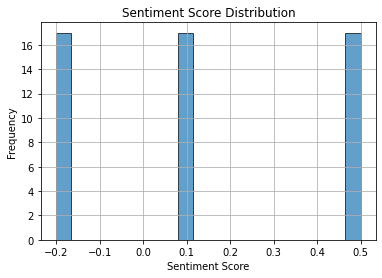

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Ensure the sentiment column is numeric
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Drop rows with NaN values in the sentiment column
df = df.dropna(subset=['sentiment'])

# Plot sentiment scores using matplotlib
plt.hist(df['sentiment'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


                         _id  id  tweet_id       date   query   user  \
0   66473329caed398a09107991   1    123456 2024-05-01  query1  user1   
1   66473329caed398a09107992   2    789012 2024-05-02  query2  user2   
2   66473329caed398a09107993   3    345678 2024-05-03  query3  user3   
3   66473cd239111bc8c45d2581   1    123456 2024-05-01  query1  user1   
4   66473cd239111bc8c45d2582   2    789012 2024-05-02  query2  user2   
5   66473cd239111bc8c45d2583   3    345678 2024-05-03  query3  user3   
6   66473fd860fab59c87374691   1    123456 2024-05-01  query1  user1   
7   66473fd860fab59c87374692   2    789012 2024-05-02  query2  user2   
8   66473fd860fab59c87374693   3    345678 2024-05-03  query3  user3   
9   6647404860fab59c87374695   1    123456 2024-05-01  query1  user1   
10  6647404860fab59c87374696   2    789012 2024-05-02  query2  user2   
11  6647404860fab59c87374697   3    345678 2024-05-03  query3  user3   
12  664747b4eaaa5deae42c6c16   1    123456 2024-05-01  query1  u

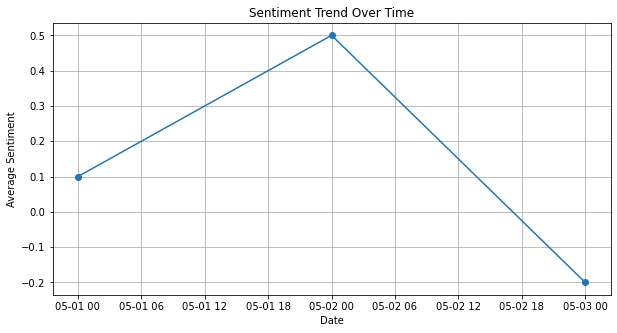

In [16]:

# Query all documents
documents = collection.find()

# Convert to DataFrame
df = pd.DataFrame(list(documents))

# Ensure the sentiment column is numeric
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Drop rows with NaN values in the sentiment column
df = df.dropna(subset=['sentiment'])

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with NaT values in the date column
df = df.dropna(subset=['date'])

# Group by date and calculate average sentiment
sentiment_trend = df.groupby('date')['sentiment'].mean().reset_index()

# Ensure there's no multi-dimensional indexing issue
sentiment_trend = sentiment_trend.reset_index(drop=True)

# Display the DataFrame and sentiment trend
print(df)
print(sentiment_trend)

# Calculate average sentiment score
average_sentiment = df['sentiment'].mean()
print(f"Average Sentiment Score: {average_sentiment}")

# Convert 'date' and 'sentiment' columns to numpy arrays for plotting
dates = sentiment_trend['date'].values
sentiments = sentiment_trend['sentiment'].values

# Plot sentiment trend over time
plt.figure(figsize=(10, 5))
plt.plot(dates, sentiments, marker='o')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


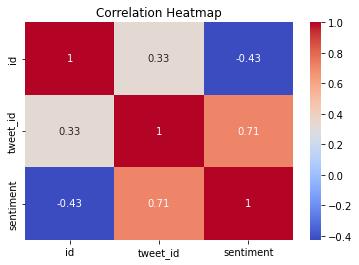

In [18]:
# Convert the PySpark DataFrame to a Pandas DataFrame
user_sentiment_pd = user_sentiment.toPandas()

# Save user sentiment analysis to CSV
user_sentiment_pd.to_csv('user_sentiment_analysis.csv', index=False)

# Insert user sentiment analysis results into MongoDB
user_sentiment_dict = user_sentiment_pd.to_dict('records')
db['user_sentiment_analysis'].insert_many(user_sentiment_dict)

# Exclude non-numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


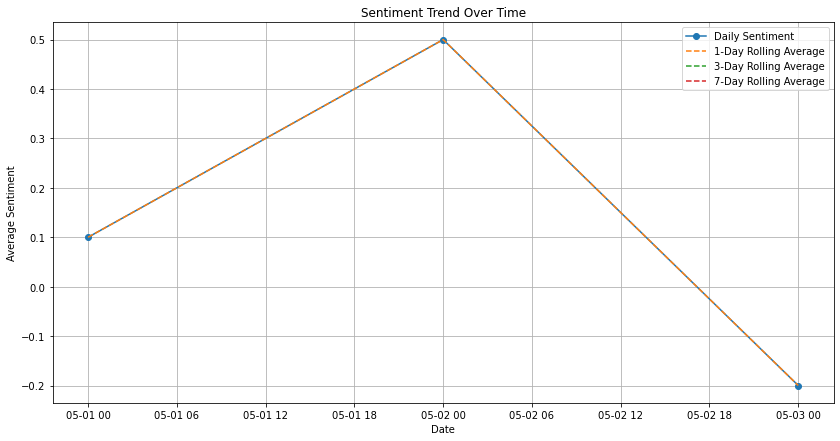

In [19]:
# Drop rows with NaT values in the date column
df = df.dropna(subset=['date'])

# Set the date as the index
df.set_index('date', inplace=True)

# Resample the data to ensure it is in daily frequency
daily_sentiment = df['sentiment'].resample('D').mean()

# Calculate rolling averages for 1-day, 3-day, and 7-day windows
rolling_1d = daily_sentiment.rolling(window=1).mean()
rolling_3d = daily_sentiment.rolling(window=3).mean()
rolling_7d = daily_sentiment.rolling(window=7).mean()

# Plot the results
plt.figure(figsize=(14, 7))

plt.plot(daily_sentiment, label='Daily Sentiment', marker='o')
plt.plot(rolling_1d, label='1-Day Rolling Average', linestyle='--')
plt.plot(rolling_3d, label='3-Day Rolling Average', linestyle='--')
plt.plot(rolling_7d, label='7-Day Rolling Average', linestyle='--')

plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Fit ARIMA model
model = ARIMA(daily_sentiment, order=(5, 1, 0))
arima_result = model.fit()

# Forecast
forecast_1d = arima_result.forecast(steps=1)
forecast_3d = arima_result.forecast(steps=3)
forecast_7d = arima_result.forecast(steps=7)

print("ARIMA Forecasts:")
print(f"1 Day: {forecast_1d}")
print(f"3 Days: {forecast_3d}")
print(f"7 Days: {forecast_7d}")


ARIMA Forecasts:
1 Day: 2024-05-04    0.40307
Freq: D, dtype: float64
3 Days: 2024-05-04    0.403070
2024-05-05   -0.116500
2024-05-06    0.331122
Freq: D, Name: predicted_mean, dtype: float64
7 Days: 2024-05-04    0.403070
2024-05-05   -0.116500
2024-05-06    0.331122
2024-05-07   -0.054525
2024-05-08    0.277722
2024-05-09   -0.008519
2024-05-10    0.238086
Freq: D, Name: predicted_mean, dtype: float64


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [21]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler



epoch:   0 loss: 0.09436588
epoch:   1 loss: 0.07605276
epoch:   2 loss: 0.06613529
epoch:   3 loss: 0.06090020
epoch:   4 loss: 0.05841412
Length of daily_sentiment index: 100
Length of predictions: 97
Length of dates_for_plotting: 97


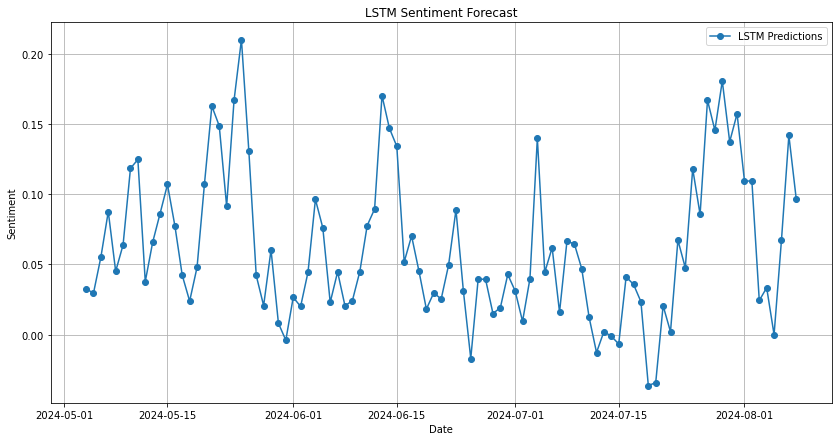

LSTM Forecasts:
[0.0326324  0.02951809 0.05513788 0.0876015  0.04506396 0.06387962
 0.11836011]


In [22]:
# Generate a sample dataset
dates = pd.date_range(start='2024-05-01', periods=100)
sentiments = np.random.randn(100)

# Create a DataFrame
df = pd.DataFrame({'date': dates, 'sentiment': sentiments})
df.set_index('date', inplace=True)

# Resample the data to ensure it is in daily frequency
daily_sentiment = df['sentiment'].resample('D').mean()

# Prepare the data
sentiment_values = daily_sentiment.values.reshape(-1, 1)
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(sentiment_values)

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
X, y = create_sequences(sentiment_scaled, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 5
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()

        y_pred = model(seq.view(1, -1, 1))  # Adjusting input shape for LSTM

        single_loss = loss_function(y_pred, labels.view(1, -1))
        single_loss.backward()
        optimizer.step()

    if i % 1 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

# Make predictions
model.eval()
predictions = []
for seq in X_train:
    with torch.no_grad():
        predictions.append(model(seq.view(1, -1, 1)).item())

# Scale back the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Flatten the predictions array
predictions = predictions.flatten()

# Check lengths of indices and predictions
print(f'Length of daily_sentiment index: {len(daily_sentiment.index)}')
print(f'Length of predictions: {len(predictions)}')

# Ensure lengths match for plotting
dates_for_plotting = daily_sentiment.index[seq_length:seq_length + len(predictions)].to_numpy()

# Flatten dates_for_plotting
dates_for_plotting = dates_for_plotting.flatten()

# Check lengths again
print(f'Length of dates_for_plotting: {len(dates_for_plotting)}')

# Ensure dates_for_plotting and predictions are the same length
assert len(dates_for_plotting) == len(predictions), "Lengths of dates and predictions do not match!"

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_for_plotting, predictions, label='LSTM Predictions', marker='o')
plt.title('LSTM Sentiment Forecast')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.grid(True)
plt.show()

print("LSTM Forecasts:")
print(predictions[:7])

In [23]:
from sklearn.model_selection import ParameterGrid

# Define a function to train the model
def train_model(hidden_units, learning_rate, epochs, batch_size):
    model = LSTMModel(hidden_layer_size=hidden_units)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    
    for epoch in range(epochs):
        for start in range(0, len(X_train), batch_size):
            end = start + batch_size
            seq = X_train[start:end]
            labels = y_train[start:end]
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

    return model, single_loss.item()

# Define hyperparameter grid
param_grid = {
    'hidden_units': [10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
    'batch_size': [10, 20, 30]
}

best_loss = float('inf')
best_params = None
best_model = None

# Perform grid search
for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")
    model, loss = train_model(params['hidden_units'], params['learning_rate'], params['epochs'], params['batch_size'])
    print(f"Loss: {loss}")
    if loss < best_loss:
        best_loss = loss
        best_params = params
        best_model = model

print(f"Best params: {best_params}")


Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 10, 'learning_rate': 0.001}
Loss: 1.2128382921218872
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 10, 'learning_rate': 0.01}
Loss: 0.6493138074874878
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 10, 'learning_rate': 0.1}
Loss: 0.7803501486778259
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 50, 'learning_rate': 0.001}
Loss: 1.295399785041809
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 50, 'learning_rate': 0.01}
Loss: 0.31187087297439575
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 50, 'learning_rate': 0.1}
Loss: 0.2522546350955963
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 100, 'learning_rate': 0.001}
Loss: 1.2301597595214844
Training with params: {'batch_size': 10, 'epochs': 50, 'hidden_units': 100, 'learning_rate': 0.01}
Loss: 0.43210741877555847
Training wit

In [24]:
# Retrain the LSTM model with the best parameters
hidden_units = best_params['hidden_units']
learning_rate = best_params['learning_rate']
epochs = best_params['epochs']
batch_size = best_params['batch_size']

model = LSTMModel(hidden_layer_size=hidden_units)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

for epoch in range(epochs):
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        seq = X_train[start:end]
        labels = y_train[start:end]
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')


epoch:   0 loss: 1.06087494
epoch:  10 loss: 1.06852508
epoch:  20 loss: 0.89833087
epoch:  30 loss: 0.71902698
epoch:  40 loss: 0.57278401
epoch:  50 loss: 0.48299453
epoch:  60 loss: 0.25835785
epoch:  70 loss: 0.09371856
epoch:  80 loss: 0.09389763
epoch:  90 loss: 0.07363065


In [25]:
!pip install dash


Defaulting to user installation because normal site-packages is not writeable


In [26]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pymongo import MongoClient

# Initialize the Dash app
app = dash.Dash(__name__)

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["twitter_sentiment"]
collection = db["tweets"]

# Fetch data from MongoDB
documents = collection.find()
df = pd.DataFrame(list(documents))

# Ensure the sentiment column is numeric
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Drop rows with NaN values in the sentiment column
df = df.dropna(subset=['sentiment'])

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with NaT values in the date column
df = df.dropna(subset=['date'])

# Group by date and calculate average sentiment
sentiment_trend = df.groupby('date')['sentiment'].mean().reset_index()

# User sentiment analysis
user_sentiment = df.groupby('user')['sentiment'].mean().reset_index()
user_sentiment_top5 = user_sentiment.nlargest(5, 'sentiment')
user_sentiment_bottom5 = user_sentiment.nsmallest(5, 'sentiment')

# Create figures for the dashboard
fig_trend = px.line(sentiment_trend, x='date', y='sentiment', title='Sentiment Trend Over Time')
fig_hist = px.histogram(df, x='sentiment', nbins=20, title='Sentiment Score Distribution')
fig_user_sentiment_top5 = px.bar(user_sentiment_top5, x='user', y='sentiment', title='Top 5 Users with Highest Average Sentiment')
fig_user_sentiment_bottom5 = px.bar(user_sentiment_bottom5, x='user', y='sentiment', title='Top 5 Users with Lowest Average Sentiment')

# Define the layout of the app
app.layout = html.Div([
    html.H1("Twitter Sentiment Analysis Dashboard"),
    
    dcc.Graph(id='trend-graph', figure=fig_trend),
    
    dcc.Graph(id='hist-graph', figure=fig_hist),
    
    html.Div([
        dcc.Graph(id='user-sentiment-top5', figure=fig_user_sentiment_top5),
        dcc.Graph(id='user-sentiment-bottom5', figure=fig_user_sentiment_bottom5)
    ], style={'display': 'flex', 'flex-direction': 'row', 'justify-content': 'space-between'})
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
